In [33]:
import scanpy as sc
import gzip
import os
import pandas as pd
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import openslide
from tifffile import imwrite

from functions import *

In [35]:
AJER376R_pth = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/LK01JHU510_000_analysis/count/AJER376R/outs'
AJGB283_pth = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/LK01JHU510_000_analysis/count/AJGB283/outs'

AJER376R_16um = os.path.join(AJER376R_pth, 'binned_outputs/square_016um')
AJGB283_16um = os.path.join(AJGB283_pth, 'binned_outputs/square_016um')

AJER376R_16um_filtered = os.path.join(AJER376R_16um, 'filtered_feature_bc_matrix')
AJGB283_16um_filtered = os.path.join(AJGB283_16um, 'filtered_feature_bc_matrix')

AJER376R_spatial = os.path.join(AJER376R_16um, 'spatial')
AJGB283_spatial = os.path.join(AJGB283_16um, 'spatial')

In [36]:
adata_AJER376R = sc.read_visium(AJER376R_16um)
df_AJER376R = make_raw_matrix(AJER376R_16um, adata_AJER376R)

adata_AJGB283 = sc.read_visium(AJGB283_16um)
df_AJGB283 = make_raw_matrix(AJGB283_16um, adata_AJGB283)

/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/scanpy/readwrite.py:482: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.p

In [4]:
# make a downsampled image of the ndpi image
AJGB283_ndpi_pth = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/H&E stained slides/AJGB283_2.ndpi'

slide = openslide.OpenSlide(AJGB283_ndpi_pth)
full_width, full_height = slide.dimensions
print(f"Full resolution dimensions: {full_width} x {full_height}")
cropped_region = slide.read_region((0, 0), 0, (full_width, full_height))
img = cropped_region.convert("RGB")

ds = 16
ds_img = np.array(img)[::ds,::ds,:]

outpth = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/H&E stained slides/downsized_by_16'
outnm = os.path.join(outpth, os.path.basename(AJGB283_ndpi_pth)[:-5])
outnm = "".join([outnm, ".tiff"])
imwrite(outnm, ds_img)

Full resolution dimensions: 73728 x 55552


Go to ImageJ, load the image that was just saved and the tissue_hires_image.png from spatial folder
Click points on both using the multipoint button, click like 7-10, focus on Visium location
Plugins -> Transform -> Landmark correspondense
Least Squares, Affine, make sure source image is the high_res image
Make sure to click "show matrix", then copy paste the afffine matrix, it is in a weird format though...

normal aff matrix:
[a b c]
[d e f]
[0 0 1]

output:
[a c e]
[b d f]

376
Matrix: [0.8488036466391021, 4.750750476953311E-4, 1.9998287263397465E-4,
        0.8496312664438789, -626.5688078311568, -2.7420075364470904]

286:
Matrix: [1.05381759957891, -4.972370436692816E-4, 1.2507908498900786E-4,
        1.0519744607876014, -857.7976626084848, 3.556737134836567]

In [38]:
aff = np.array([[0.8488036466391021, 4.750750476953311E-4, -626.5688078311568],
       [1.9998287263397465E-4, 0.8496312664438789, -2.7420075364470904],
       [0, 0, 1]])

# aff = np.array([[1.05381759957891, -4.972370436692816E-4,-857.7976626084848],
#                 [1.2507908498900786E-4, 1.0519744607876014, 3.556737134836567],
#                 [0, 0, 1]])

# import pickle

# out_aff = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/H&E stained slides/downsized_by_16/AJGB283_2_aff.pkl'
# with open(out_aff, 'wb') as f:
#     pickle.dump(aff, f)

In [39]:
buffer_size = 4096
ds = 16
adata_AJER376R, AJER376R_npdi_crop_coords = make_full_res_xy(adata_AJER376R, AJER376R_spatial, aff, ds, buffer_size)

In [40]:
AJER376R_ndpi_pth = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/H&E stained slides/AJER376R_2.ndpi'
AJER376R_ndpi_cropped = read_ndpi(AJER376R_ndpi_pth, AJER376R_npdi_crop_coords)

Full resolution dimensions: 61440 x 44800


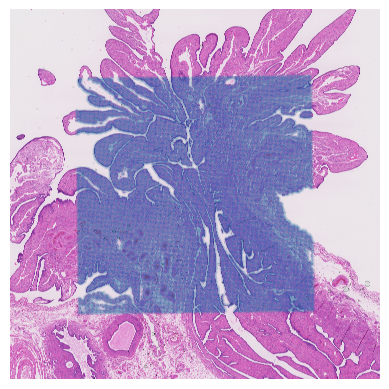

In [41]:
x_offset = AJER376R_npdi_crop_coords[0]
y_offset = AJER376R_npdi_crop_coords[2]

plt.imshow(AJER376R_ndpi_cropped)
plt.scatter(adata_AJER376R.obsm['spatial'][:,0]-x_offset,adata_AJER376R.obsm['spatial'][:,1]-y_offset,s=0.001)
plt.axis('off')
plt.show()

In [13]:
outpth = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/LK01JHU510_000_analysis/count/AJER376R/outs/binned_outputs/square_016um/donald_analysis/AJER376R_training'
outnm = os.path.join(outpth, 'AJER376R_visium_cropped.png')

AJER376R_ndpi_cropped.save(outnm)

In [42]:
# read parquet if exists
tissue_positions_pth = os.path.join(AJER376R_spatial, 'tissue_positions.parquet')
tissue_positions_df = pd.read_parquet(tissue_positions_pth)
tissue_positions_df = tissue_positions_df.loc[tissue_positions_df['in_tissue']==1]
tissue_positions_df_processed = tissue_positions_df[['barcode', 'pxl_row_in_fullres', 'pxl_col_in_fullres']]

tissue_positions_df_processed.rename(columns={
    'barcode': 'Spot', 
    'pxl_row_in_fullres': 'x',  # Corrected to match the original column name
    'pxl_col_in_fullres': 'y'    # Corrected to match the original column name
}, inplace=True)

x = adata_AJER376R.obsm['spatial'][:,0]-x_offset
y = adata_AJER376R.obsm['spatial'][:,1]-y_offset

tissue_positions_df_processed['x'] = x
tissue_positions_df_processed['y'] = y

tissue_positions_df_processed.head()

/tmp/ipykernel_588712/1941486580.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tissue_positions_df_processed.rename(columns={
/tmp/ipykernel_588712/1941486580.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tissue_positions_df_processed['x'] = x
/tmp/ipykernel_588712/1941486580.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

,Spot,x,y
0,s_016um_00000_00000-1,7112.681641,17093.302734
1,s_016um_00000_00001-1,17132.648438,18447.541016
2,s_016um_00000_00002-1,17766.023438,10430.105469
3,s_016um_00000_00003-1,6291.371094,5018.449219
4,s_016um_00000_00004-1,10334.798828,13822.042969


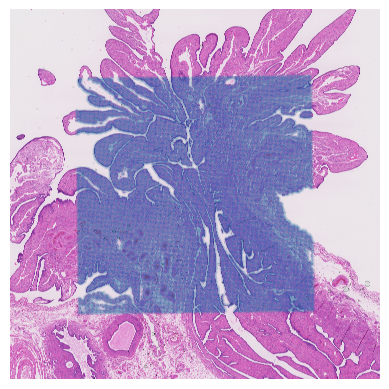

In [43]:
plt.imshow(AJER376R_ndpi_cropped)
plt.scatter(tissue_positions_df_processed['x'],tissue_positions_df_processed['y'],s=0.001)
plt.axis('off')
plt.show()

In [44]:
raw_df = adata_AJER376R.X.toarray()

# Load barcodes (spot identifiers)
barcodes_file = os.path.join(AJER376R_16um_filtered, "barcodes.tsv.gz")

# Since the barcodes are gzipped, we'll read them using gzip
with gzip.open(barcodes_file, 'rt') as f:
    barcodes = [line.strip() for line in f.readlines()]

# Load gene names (features)
features_file = os.path.join(AJER376R_16um_filtered, "features.tsv.gz")
with gzip.open(features_file, 'rt') as f:
    features = [line.strip().split("\t")[1] for line in f.readlines()]

AJER376R_df = pd.DataFrame(raw_df, index=barcodes, columns=features)

# filter in tissue
#AJER376R_df = AJER376R_df.loc[tissue_positions_df['in_tissue']==1]

AJER376R_df.head()

,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,RNF223,C1orf159,...,MT-ND2,MT-CO2,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB
s_016um_00052_00082-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
s_016um_00010_00367-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_016um_00238_00388-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_016um_00396_00063-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,2.0,2.0,1.0,0.0,1.0,2.0,1.0
s_016um_00144_00175-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [45]:
print(AJER376R_df.shape)
print(tissue_positions_df_processed.shape)

(157222, 18085)
(157222, 3)


/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/scanpy/readwrite.py:482: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.p

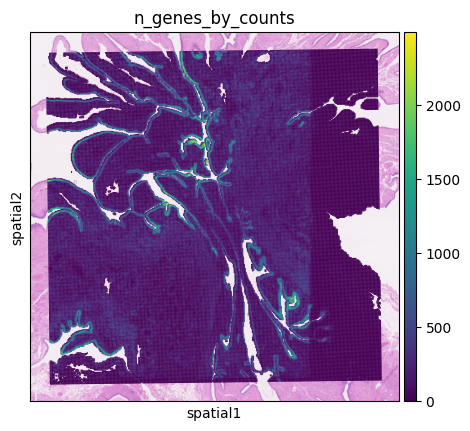

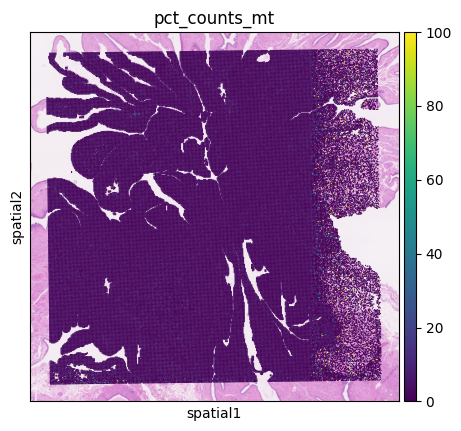

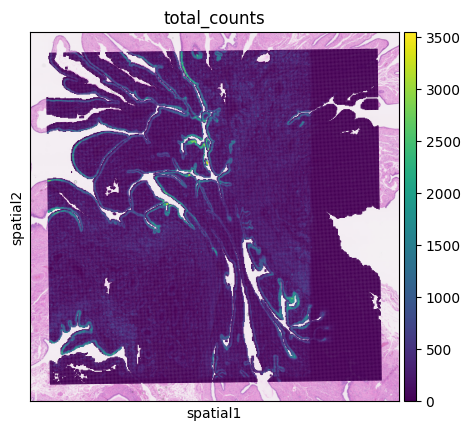

In [46]:
adata_AJER376R_QC = sc.read_visium(AJER376R_16um)
adata_AJER376R_QC = fix_xy(adata_AJER376R_QC)
adata_AJER376R_QC = qc_spots_and_norm(adata_AJER376R_QC, 0, 0, False, False)
sc.pl.spatial(adata_AJER376R_QC, img_key="hires", color="n_genes_by_counts", size=1.5)
sc.pl.spatial(adata_AJER376R_QC, img_key="hires", color="pct_counts_mt", size=1.5)
sc.pl.spatial(adata_AJER376R_QC, img_key="hires", color="total_counts", size=1.5)

/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/scanpy/readwrite.py:482: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.p

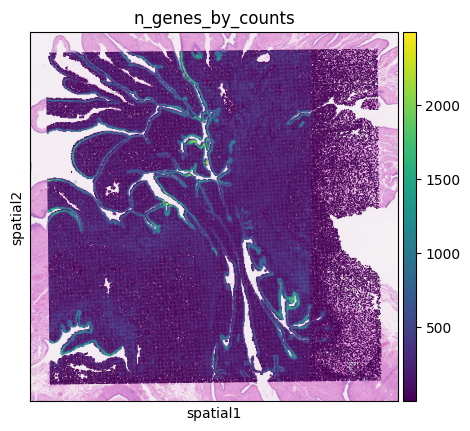

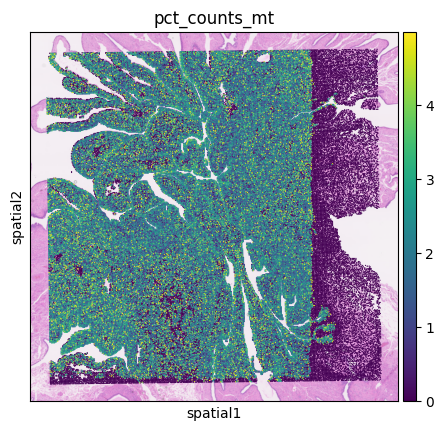

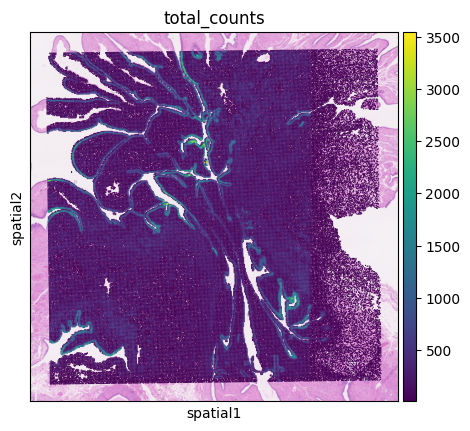

In [47]:
adata_AJER376R_QC = sc.read_visium(AJER376R_16um)
adata_AJER376R_QC = fix_xy(adata_AJER376R_QC)
adata_AJER376R_QC = qc_spots_and_norm(adata_AJER376R_QC, 0, 50, True, False,1000)
sc.pl.spatial(adata_AJER376R_QC, img_key="hires", color="n_genes_by_counts", size=1.5)
sc.pl.spatial(adata_AJER376R_QC, img_key="hires", color="pct_counts_mt", size=1.5)
sc.pl.spatial(adata_AJER376R_QC, img_key="hires", color="total_counts", size=1.5)

In [48]:
QCd_spots = adata_AJER376R_QC.obs.index.tolist()
print(len(QCd_spots))
print(AJER376R_df.shape)
print(tissue_positions_df_processed.shape)

139487
(157222, 18085)
(157222, 3)


In [49]:
out_df = AJER376R_df.loc[QCd_spots]
out_pos = tissue_positions_df_processed[tissue_positions_df_processed['Spot'].isin(QCd_spots)]

print(out_df.shape)
print(out_pos.shape)

(139487, 18085)
(139487, 3)


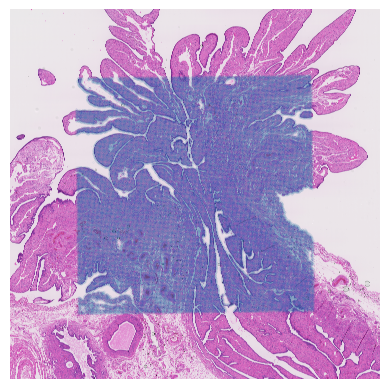

In [50]:
plt.imshow(AJER376R_ndpi_cropped)
plt.scatter(out_pos['x'],out_pos['y'],s=0.001)
plt.axis('off')
plt.show()

In [24]:
out_folder = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/LK01JHU510_000_analysis/count/AJER376R/outs/binned_outputs/square_016um/donald_analysis/AJER376R_training'

outpth = os.path.join(out_folder, "locs.tsv")
out_pos.to_csv(outpth, sep='\t')

In [52]:
adata_AJER376R_QC = sc.read_visium(AJER376R_16um)
out_df = AJER376R_df.loc[QCd_spots]
print(out_df.shape)

/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/scanpy/readwrite.py:482: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(


(139487, 18085)


In [53]:
out_df.head()

,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,RNF223,C1orf159,...,MT-ND2,MT-CO2,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB
s_016um_00052_00082-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
s_016um_00396_00063-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,2.0,2.0,1.0,0.0,1.0,2.0,1.0
s_016um_00144_00175-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
s_016um_00297_00147-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
s_016um_00299_00088-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
out_folder = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/LK01JHU510_000_analysis/count/AJER376R/outs/binned_outputs/square_016um/donald_analysis/AJER376R_training'

outpth = os.path.join(out_folder, "cnts.tsv")
out_df.to_csv(outpth, sep='\t')

: 

In [17]:
pth_scale_factors = os.path.join(AJER376R_spatial, 'scalefactors_json.json')

with open(pth_scale_factors, 'rb') as f:
    scale_factors = json.load(f)

In [18]:
scale_factors

{'spot_diameter_fullres': 3.3074585177914844,
 'bin_size_um': 16.0,
 'microns_per_pixel': 4.837551223676059,
 'regist_target_img_scalef': 0.78125,
 'tissue_lowres_scalef': 0.078125,
 'fiducial_diameter_fullres': 68.21633192944937,
 'tissue_hires_scalef': 0.78125}

In [23]:
out_folder = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/LK01JHU510_000_analysis/count/AJER376R/outs/binned_outputs/square_016um/donald_analysis/AJER376R_training'
print(out_folder)

/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/LK01JHU510_000_analysis/count/AJER376R/outs/binned_outputs/square_016um/donald_analysis/AJER376R_training


In [24]:
# Given values from the scale factors
microns_per_pixel = 0.4536
spot_diameter_um = scale_factors['bin_size_um']/microns_per_pixel

# Calculate the radius in micrometers
spot_radius_um = spot_diameter_um / 2

# Calculate the radius in pixels
spot_radius_pixels = (spot_radius_um / microns_per_pixel)

# Output the results
print(f"Spot Radius in Pixels: {spot_radius_pixels/2}")
print(f"Pixel Size: {microns_per_pixel}")

outpth_pixel_size = os.path.join(out_folder, 'pixel-size-raw.txt')
with open(outpth_pixel_size, 'w') as f:
    f.write(str(microns_per_pixel))

outpth_radius_size = os.path.join(out_folder, 'radius-raw.txt')
with open(outpth_radius_size, 'w') as f:
    f.write(str(spot_diameter_um/2))

Spot Radius in Pixels: 19.440789576004153
Pixel Size: 0.4536
